In [365]:
import os
from itertools import product

from tqdm import tqdm_notebook as tqdm
import glob
import numpy as np
import pandas as pd
import math

In [366]:
from functools import reduce
from sklearn.metrics import roc_auc_score

def multi_roc_auc_score(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    columns = y_true.shape[1]
    column_losses = []
    for i in range(0, columns):
        column_losses.append(roc_auc_score(y_true[:, i], y_pred[:, i]))
    return np.array(column_losses).mean()

def read_predictions(prediction_dir, concat_mode='concat', per_label=False):
    labels = pd.read_csv(os.path.join(prediction_dir, 'labels.csv'))

    filepaths_train, filepaths_test = [], []
    for filepath in sorted(glob.glob('{}/*'.format(prediction_dir))):
        if filepath.endswith('predictions_train_oof.csv'):
            filepaths_train.append(filepath)
        elif filepath.endswith('predictions_test_oof.csv'):
            filepaths_test.append(filepath)

    train_dfs = []
    for filepath in filepaths_train:
        train_dfs.append(pd.read_csv(filepath))
    train_dfs = reduce(lambda df1, df2: pd.merge(df1, df2, on=['id', 'fold_id']), train_dfs)
    train_dfs.columns = _clean_columns(train_dfs, keep_colnames = ['id','fold_id'])
    train_dfs = pd.merge(train_dfs, labels, on=['id'])

    test_dfs = []
    for filepath in filepaths_test:
        test_dfs.append(pd.read_csv(filepath))
    test_dfs = reduce(lambda df1, df2: pd.merge(df1, df2, on=['id', 'fold_id']), test_dfs)
    test_dfs.columns = _clean_columns(test_dfs, keep_colnames = ['id','fold_id'])

    return train_dfs, test_dfs

def _clean_columns(df, keep_colnames):
    new_colnames = []
    for i,colname in enumerate(df.columns):
        if colname not in keep_colnames:
            new_colnames.append(i)
        else:
            new_colnames.append(colname)
    return new_colnames

def logit(p):
    return np.log(p) - np.log(1 - p)

def get_fold_xy(train, test, label_columns,i):
    train_split = train[train['fold_id'] != i]
    valid_split = train[train['fold_id'] == i]
    test_split = test[test['fold_id'] == i]

    y_train = train_split[label_columns].values
    y_valid = valid_split[label_columns].values
    columns_to_drop_train = label_columns + ['id','fold_id']
    X_train = train_split.drop(columns_to_drop_train, axis=1).values
    X_valid = valid_split.drop(columns_to_drop_train, axis=1).values

    columns_to_drop_test = ['id','fold_id']
    X_test = test_split.drop(columns_to_drop_test, axis=1).values
    return (X_train, y_train), (X_valid, y_valid), X_test
    

def stack_per_label(X, label_nr=6):
    n,k =X.shape
    model_nr = int(k/label_nr)
    X_ = []
    for i in range(model_nr):
        X_.append(X[:,i*label_nr:(i+1)*label_nr])
    X_ = np.stack(X_, axis=-1)
    return X_

def get_model_names(prediction_dir):
    suffix = '_predictions_test_oof.csv'
    filepaths = sorted([path.replace(suffix,'') for path in os.listdir(prediction_dir) if suffix in path])
    return filepaths

In [176]:
get_model_names(SINGLE_DIR)

['bad_word_logreg',
 'char_vdcnn',
 'count_logreg',
 'fasttext_dpcnn',
 'fasttext_gru',
 'fasttext_lstm',
 'fasttext_scnn',
 'glove_dpcnn',
 'glove_gru',
 'glove_lstm',
 'glove_scnn',
 'tfidf_logreg',
 'word2vec_dpcnn',
 'word2vec_gru',
 'word2vec_lstm',
 'word2vec_scnn']

In [154]:
LABEL_COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# SINGLE_DIR = '/public/toxic_comments/single_model_predictions_20180226'
# ENSEMBLE_SUBMISSION_PATH = '/output/catboost_submission.csv'

SINGLE_DIR = '/mnt/ml-team/minerva/toxic/single_model_predictions_03092018'
ENSEMBLE_SUBMISSION_PATH = '/mnt/ml-team/homes/jakub.czakon/xgboost_per_label_submission.csv'

In [156]:
train, test = read_predictions(SINGLE_DIR)

In [168]:
model_names = get_model_names(SINGLE_DIR)

for i, model_name in enumerate(model_names):
    print(i, model_name)

0 bad_word_logreg
1 char_vdcnn
2 count_logreg
3 fasttext_dpcnn
4 fasttext_gru
5 fasttext_lstm
6 fasttext_scnn
7 glove_dpcnn
8 glove_gru
9 glove_lstm
10 glove_scnn
11 tfidf_logreg
12 word2vec_dpcnn
13 word2vec_gru
14 word2vec_lstm
15 word2vec_scnn


# Let's explore the correlations

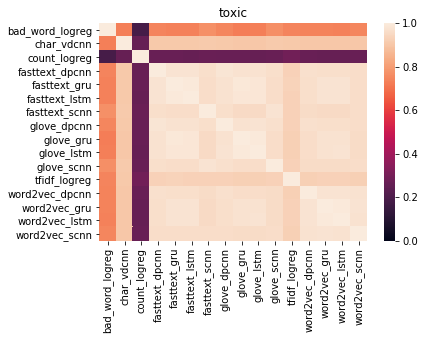

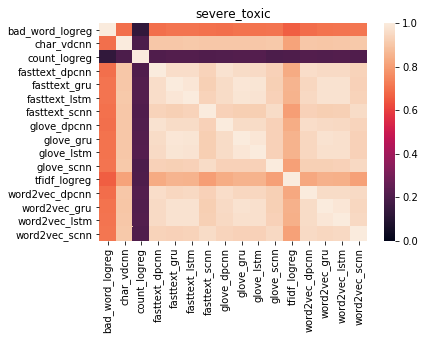

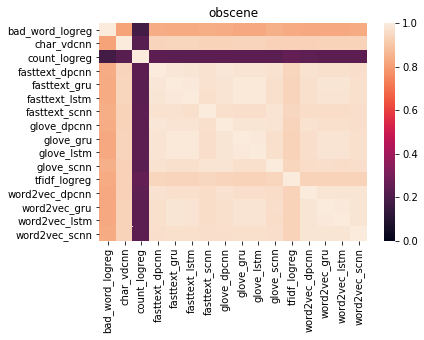

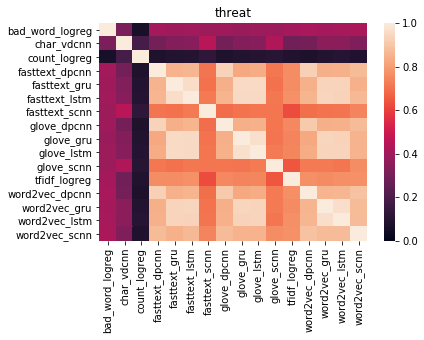

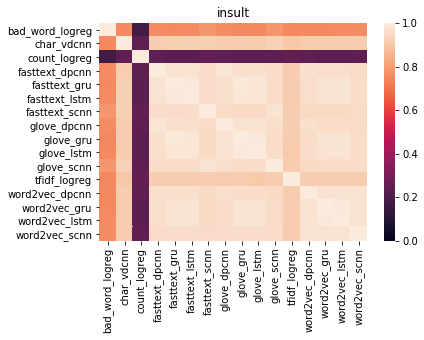

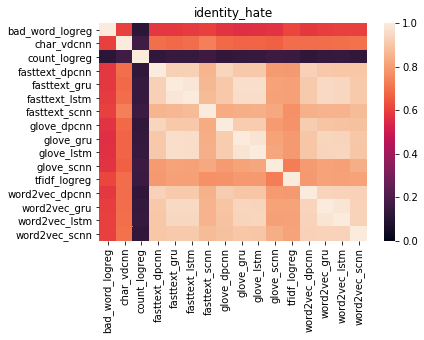

In [251]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


for i, label in enumerate(LABEL_COLUMNS):
    label_predictions = pd.DataFrame(X_train_per_label[:,i,:],columns = model_names)
    correlation_mat = label_predictions.corr()
    plt.title(label)
    sns.heatmap(correlation_mat, vmin=0.0, vmax=1.0)
    plt.show()

# Per-label Model

# Ensemble Training

In [367]:
def fit_cv(estimator, params, train, test, label_id, n_splits=10):
    estimators,scores, test_predictions = [],[],[]   
    for i in tqdm_notebook(range(n_splits)):
        (X_train, y_train), (X_valid, y_valid), X_test = get_fold_xy(train, test, LABEL_COLUMNS,i)
        X_train = stack_per_label(X_train)[:,label_id,:]
        X_valid = stack_per_label(X_valid)[:,label_id,:]
        X_test = stack_per_label(X_test)[:,label_id,:]

        y_train = y_train[:,label_id]
        y_valid = y_valid[:,label_id]
        
        estimator_ = estimator(**params) 
        estimator_.fit(X_train, y_train)
        y_valid_pred = estimator_.predict_proba(X_valid)[:,1]
        y_test_pred = estimator_.predict_proba(X_test)[:,1]
        score = roc_auc_score(y_valid, y_valid_pred)
        estimators.append(estimator_)
        scores.append(score)
        test_predictions.append(y_test_pred)
    return scores, estimators, test_predictions   

def make_grid(param_grid):
    keys, values = zip(*param_grid.items())
    param_dicts = [dict(zip(keys, v)) for v in product(*values)]
    return param_dicts

In [368]:
valid_scores, predictions_test = {}, {}

# Toxic

The default model

```python
estimator = XGBClassifier
    
params = dict(objective= 'binary:logistic',
  eval_metric= 'auc',
  n_estimators= 125,
  learning_rate= 0.1,
  max_depth= 3,
  min_child_weight= 10,
  gamma=0.0,
  subsample= 0.8,
  colsample_bytree= 0.45, #0.3-0.5
  reg_lambda= 0.2, #0.05
  reg_alpha= 0.0,
  n_jobs=12)

```

gets **0.98704**  10-fold CV

In [371]:
from xgboost import XGBClassifier

estimator = XGBClassifier
    
param_grid = dict(objective= ['binary:logistic'],
  eval_metric= ['auc'],
  n_estimators= [75],
  learning_rate= [0.1],
  max_depth= [3,4,5],
  min_child_weight= [10],
  gamma=[0.0],
  subsample= [0.8],
  colsample_bytree= [0.45], #0.3-0.5
  reg_lambda= [0.2], #0.05
  reg_alpha= [0.0],
  n_jobs=[12])

In [ ]:
label_id = 0

for params in make_grid(param_grid):
    scores, estimators, test_prediction = fit_cv(estimator, params, train, test, label_id, n_splits=10)  
    valid_scores['toxic'] = scores
    predictions_test['toxic'] = test_prediction
    print(params)
    print('mean {} std {}'.format(np.mean(scores), np.std(scores))) 

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))



{'learning_rate': 0.1, 'n_jobs': 12, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.8, 'reg_lambda': 0.2, 'colsample_bytree': 0.45, 'n_estimators': 75, 'max_depth': 3, 'min_child_weight': 10, 'reg_alpha': 0.0, 'gamma': 0.0}
mean 0.9869603258861988 std 0.001212455751762655


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


{'learning_rate': 0.1, 'n_jobs': 12, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'subsample': 0.8, 'reg_lambda': 0.2, 'colsample_bytree': 0.45, 'n_estimators': 75, 'max_depth': 4, 'min_child_weight': 10, 'reg_alpha': 0.0, 'gamma': 0.0}
mean 0.9870108061874397 std 0.0011900749849787947


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

# Severe Toxic

The default model

```python
estimator = XGBClassifier
    
params = dict(objective= 'binary:logistic',
  eval_metric= 'auc',
  n_estimators= 125,
  learning_rate= 0.1,
  max_depth= 3,
  min_child_weight= 10,
  gamma=0.0,
  subsample= 0.8,
  colsample_bytree= 0.45, #0.3-0.5
  reg_lambda= 0.2, #0.05
  reg_alpha= 0.0,
  n_jobs=12)

```

gets **0.99113**  10-fold CV

In [303]:
estimator = XGBClassifier
    
param_grid = dict(objective= ['binary:logistic'],
  eval_metric= ['auc'],
  n_estimators= [125],
  learning_rate= [0.1],
  max_depth= [3],
  min_child_weight= [10],
  gamma=[0.0],
  subsample= [0.8],
  colsample_bytree= [0.45], #0.3-0.5
  reg_lambda= [0.2], #0.05
  reg_alpha= [0.0],
  n_jobs=[12])

In [304]:
label_id = 1

for params in make_grid(param_grid):
    scores, estimators, test_prediction = fit_cv(estimator, params, train, test, label_id, n_splits=10)  
    valid_scores['severe_toxic'] = scores
    predictions_test['severe_toxic'] = test_prediction
    print(params)
    print('mean {} std {}'.format(np.mean(scores), np.std(scores))) 

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


mean 0.9911290450415713 std 0.0008036477385737881


# Obscene

The default model

```python
estimator = XGBClassifier
    
params = dict(objective= 'binary:logistic',
  eval_metric= 'auc',
  n_estimators= 125,
  learning_rate= 0.1,
  max_depth= 3,
  min_child_weight= 10,
  gamma=0.0,
  subsample= 0.8,
  colsample_bytree= 0.45, #0.3-0.5
  reg_lambda= 0.2, #0.05
  reg_alpha= 0.0,
  n_jobs=12)

```

gets **0.99501**  10-fold CV

In [305]:
estimator = XGBClassifier
    
param_grid = dict(objective= ['binary:logistic'],
  eval_metric= ['auc'],
  n_estimators= [125],
  learning_rate= [0.1],
  max_depth= [3],
  min_child_weight= [10],
  gamma=[0.0],
  subsample= [0.8],
  colsample_bytree= [0.45], #0.3-0.5
  reg_lambda= [0.2], #0.05
  reg_alpha= [0.0],
  n_jobs=[12])

In [306]:
label_id = 2

for params in make_grid(param_grid):
    scores, estimators, test_prediction = fit_cv(estimator, params, train, test, label_id, n_splits=10)  
    valid_scores['obscene'] = scores
    predictions_test['obscene'] = test_prediction
    print(params)
    print('mean {} std {}'.format(np.mean(scores), np.std(scores))) 

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


mean 0.9950070778359438 std 0.0002164730252933837


# Threat

The default model

```python
estimator = XGBClassifier
    
params = dict(objective= 'binary:logistic',
  eval_metric= 'auc',
  n_estimators= 125,
  learning_rate= 0.1,
  max_depth= 3,
  min_child_weight= 10,
  gamma=0.0,
  subsample= 0.8,
  colsample_bytree= 0.45, #0.3-0.5
  reg_lambda= 0.2, #0.05
  reg_alpha= 0.0,
  n_jobs=12)

```

gets **0.99296**  10-fold CV

In [307]:
estimator = XGBClassifier
    
param_grid = dict(objective= ['binary:logistic'],
  eval_metric= ['auc'],
  n_estimators= [125],
  learning_rate= [0.1],
  max_depth= [3],
  min_child_weight= [10],
  gamma=[0.0],
  subsample= [0.8],
  colsample_bytree= [0.45], #0.3-0.5
  reg_lambda= [0.2], #0.05
  reg_alpha= [0.0],
  n_jobs=[12])

In [308]:
label_id = 3

for params in make_grid(param_grid):
    scores, estimators, test_prediction = fit_cv(estimator, params, train, test, label_id, n_splits=10)  
    valid_scores['threat'] = scores
    predictions_test['threat'] = test_prediction
    print(params)
    print('mean {} std {}'.format(np.mean(scores), np.std(scores))) 

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


mean 0.9929632739713957 std 0.00309292098682042


# Insult

The default model

```python
estimator = XGBClassifier
    
params = dict(objective= 'binary:logistic',
  eval_metric= 'auc',
  n_estimators= 125,
  learning_rate= 0.1,
  max_depth= 3,
  min_child_weight= 10,
  gamma=0.0,
  subsample= 0.8,
  colsample_bytree= 0.45, #0.3-0.5
  reg_lambda= 0.2, #0.05
  reg_alpha= 0.0,
  n_jobs=12)

```

gets **0.989208**  10-fold CV

In [309]:
estimator = XGBClassifier
    
param_grid = dict(objective= ['binary:logistic'],
  eval_metric= ['auc'],
  n_estimators= [125],
  learning_rate= [0.1],
  max_depth= [3],
  min_child_weight= [10],
  gamma=[0.0],
  subsample= [0.8],
  colsample_bytree= [0.45], #0.3-0.5
  reg_lambda= [0.2], #0.05
  reg_alpha= [0.0],
  n_jobs=[12])

In [310]:
label_id = 4

for params in make_grid(param_grid):
    scores, estimators, test_prediction = fit_cv(estimator, params, train, test, label_id, n_splits=10)  
    valid_scores['insult'] = scores
    predictions_test['insult'] = test_prediction
    print(params)
    print('mean {} std {}'.format(np.mean(scores), np.std(scores))) 

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


mean 0.9892077720541466 std 0.0010903884343266917


# Identity Hate

The default model

```python
estimator = XGBClassifier
    
params = dict(objective= 'binary:logistic',
  eval_metric= 'auc',
  n_estimators= 125,
  learning_rate= 0.1,
  max_depth= 3,
  min_child_weight= 10,
  gamma=0.0,
  subsample= 0.8,
  colsample_bytree= 0.45, #0.3-0.5
  reg_lambda= 0.2, #0.05
  reg_alpha= 0.0,
  n_jobs=12)

```

gets **0.990216**  10-fold CV

In [311]:
estimator = XGBClassifier
    
param_grid = dict(objective= ['binary:logistic'],
  eval_metric= ['auc'],
  n_estimators= [125],
  learning_rate= [0.1],
  max_depth= [3],
  min_child_weight= [10],
  gamma=[0.0],
  subsample= [0.8],
  colsample_bytree= [0.45], #0.3-0.5
  reg_lambda= [0.2], #0.05
  reg_alpha= [0.0],
  n_jobs=[12])

In [312]:
label_id = 5

for params in make_grid(param_grid):
    scores, estimators, test_prediction = fit_cv(estimator, params, train, test, label_id, n_splits=10)  
    valid_scores['identity_hate'] = scores
    predictions_test['identity_hate'] = test_prediction
    print(params)
    print('mean {} std {}'.format(np.mean(scores), np.std(scores))) 

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


mean 0.9902160596854352 std 0.002572263545752431


# Combine

In [313]:
final_cv_score = []
for label, scores in valid_scores.items():
    final_cv_score.append(np.mean(scores))
    print(label, np.mean(scores),np.std(scores))
print(np.mean(final_cv_score))

threat 0.9929632739713957 0.00309292098682042
toxic 0.9870395292955839 0.0012145984403526355
identity_hate 0.9902160596854352 0.002572263545752431
severe_toxic 0.9911290450415713 0.0008036477385737881
insult 0.9892077720541466 0.0010903884343266917
obscene 0.9950070778359438 0.0002164730252933837
0.9909271263140128


# Lets explore out of fold predictions as explained here 

https://www.kaggle.com/ogrellier/things-you-need-to-be-aware-of-before-stacking

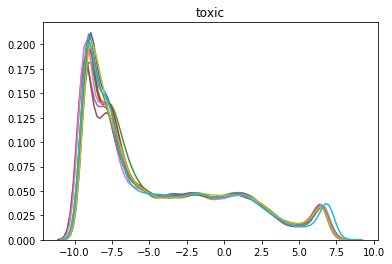

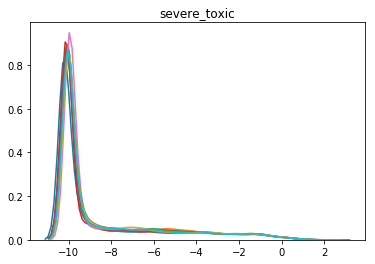

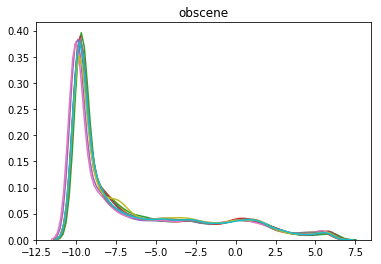

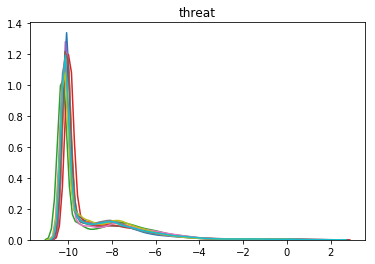

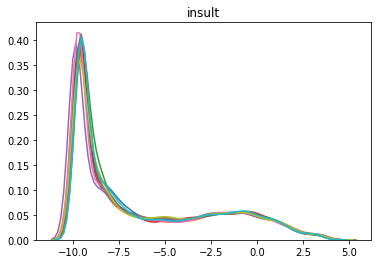

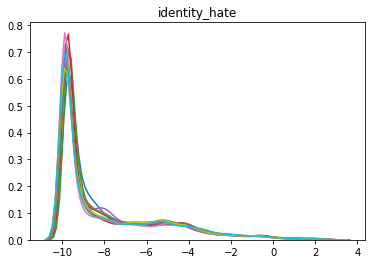

In [320]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

for l, label in enumerate(LABEL_COLUMNS):
    predictions = predictions_test[label]
    for fold_predictions in predictions:
        fold_predictions_logit = np.log((fold_predictions + 1e-5) / (1 - fold_predictions + 1e-5))
        sns.distplot(fold_predictions_logit, hist=False)
    plt.title(label)
    plt.show()

# Olivier's (kaggle kernel) ranking can be applied to out of fold predictions

In [321]:
def oof_scaling(predictions):
    predictions = pd.DataFrame(predictions)
    predictions = (1 + predictions.rank().values) / (predictions.shape[0] + 1)
    return predictions

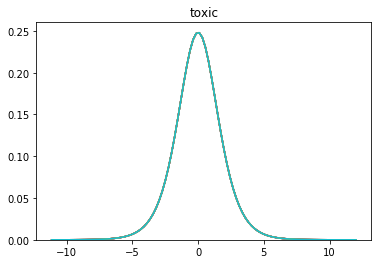

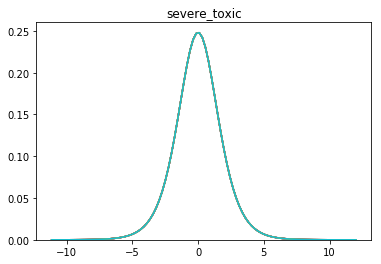

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f1f3494a2e8>>
Traceback (most recent call last):
  File "/mnt/ml-team/homes/jakub.czakon/.env/dl_py3/lib/python3.5/site-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


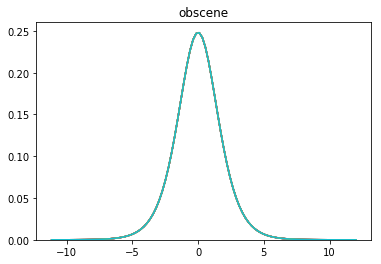

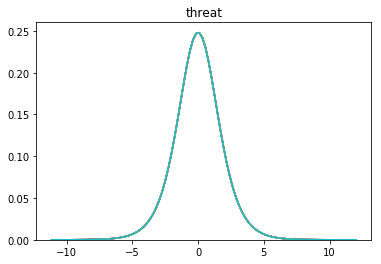

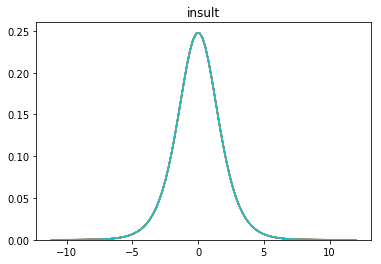

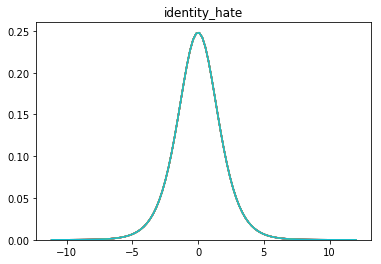

In [324]:
for l, label in enumerate(LABEL_COLUMNS):
    predictions = predictions_test[label]
    for fold_predictions in predictions:
        fold_predictions = oof_scaling(fold_predictions)
        fold_predictions_logit = np.log((fold_predictions + 1e-5) / (1 - fold_predictions + 1e-5))
        sns.distplot(predictions_logit, hist=False)
    plt.title(label)
    plt.show()

In [334]:
combined_predictions = {}
for label, predictions in predictions_test.items():
    oof_predictions = [oof_scaling(fold_predictions) for fold_predictions in predictions]
    oof_predictions_mean = np.mean(np.stack(oof_predictions, axis=-1),axis=-1).reshape(-1)
    combined_predictions[label] = oof_predictions_mean.tolist()
combined_predictions = pd.DataFrame(combined_predictions)

In [335]:
combined_predictions.head()

,identity_hate,insult,obscene,severe_toxic,threat,toxic
0,0.984510,0.985405,0.967340,0.981914,0.989897,0.973503
1,0.236978,0.264973,0.255327,0.528263,0.178033,0.288352
2,0.410609,0.500640,0.438777,0.639613,0.479523,0.469850
3,0.079368,0.132776,0.062273,0.217516,0.242370,0.042528
4,0.241264,0.380670,0.359586,0.433329,0.500983,0.483811


In [336]:
submission = sample_submission
submission[LABEL_COLUMNS] = combined_predictions[LABEL_COLUMNS].values 
submission.to_csv(ENSEMBLE_SUBMISSION_PATH, index=None)
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.973503,0.981914,0.967340,0.989897,0.985405,0.984510
1,0000247867823ef7,0.288352,0.528263,0.255327,0.178033,0.264973,0.236978
2,00013b17ad220c46,0.469850,0.639613,0.438777,0.479523,0.500640,0.410609
3,00017563c3f7919a,0.042528,0.217516,0.062273,0.242370,0.132776,0.079368
4,00017695ad8997eb,0.483811,0.433329,0.359586,0.500983,0.380670,0.241264
